# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [38]:
X_train = np.loadtxt('X_train.txt')
y_train = np.loadtxt('y_train.txt', dtype=int)

X_test = np.loadtxt('X_test.txt')
y_test = np.loadtxt('y_test.txt', dtype=int)

In [39]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [40]:
# Ваш код здесь
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Определим число уникальных значений меток целевого класса.

In [41]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [42]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [43]:
# Ваш код здесь
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f'std: {np.round(X_scaled.std(axis=0)[:10], 5)}')
print(f'mean: {np.round(X_scaled.mean(axis=0)[:10], 5)}')

std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
mean: [ 0. -0. -0. -0.  0. -0. -0.  0.  0.  0.]


Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [44]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [45]:
# Ваш код здесь
print('Количество компонент, которые нужно выделить,\n' \
        f'чтобы объяснить 90% дисперсии отмасштабированных данных: {pca.n_components_}')

Количество компонент, которые нужно выделить,
чтобы объяснить 90% дисперсии отмасштабированных данных: 65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [46]:
# Ваш код здесь
value = round(pca.explained_variance_ratio_[0] * 100)
print(f'{value}% дисперсии приходится на первую главную компоненту.')

51% дисперсии приходится на первую главную компоненту.


Визуализируйте данные в проекции на первые две главные компоненты.

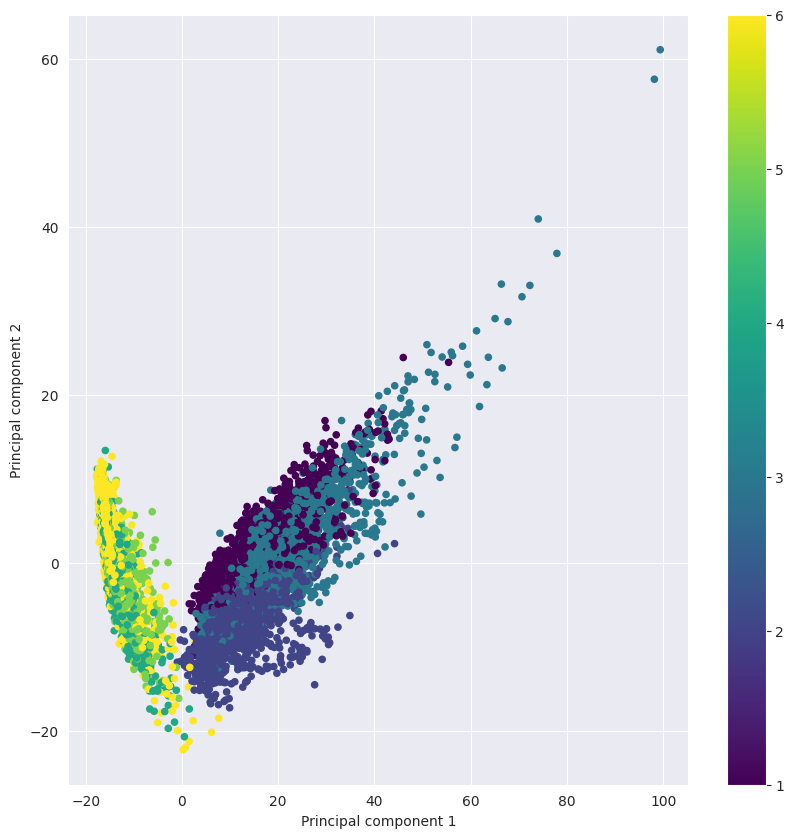

In [47]:
# Ваш код здесь
plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.colorbar()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- **6 кластеров**

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [48]:
# Ваш код здесь
class MyKMeans:
    def __init__(self, n_clusters, n_init=10, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = None
        if random_state is not None:
            np.random.seed(random_state)
    
    def _initialize_centroids(self, X_data):
        indices = np.random.choice(X_data.shape[0], self.n_clusters, replace=False)
        return X_data[indices].copy()
    
    def _calculate_distances(self, X_data, centroids):
        return np.linalg.norm(X_data[:, np.newaxis] - centroids[np.newaxis, :], axis=2)
    
    def _get_clusters(self, distances):
        return np.argmin(distances, axis=1)
    
    def _update_centroids(self, X_data, labels, old_centroids):
        new_centroids = np.zeros_like(old_centroids)
        for i in range(self.n_clusters):
            cluster_mask = (labels == i)
            new_centroids[i] = X_data[cluster_mask].mean(axis=0) if np.any(cluster_mask) else old_centroids[i]
        return new_centroids
    
    def _compute_inertia(self, X_data, labels, centroids):
        inertia = 0.0
        for i in range(self.n_clusters):
            cluster_mask = (labels == i)
            if np.any(cluster_mask):
                inertia += np.sum((X_data[cluster_mask] - centroids[i]) ** 2)
        return inertia
    
    def fit(self, X_data):
        X_data = np.array(X_data)
        best_inertia, best_n_iter = np.inf, 0
        best_labels, best_centroids = None, None
        
        for _ in range(self.n_init):
            centroids = self._initialize_centroids(X_data)
            labels = None
            
            for i in range(self.max_iter):
                distances = self._calculate_distances(X_data, centroids)
                labels = self._get_clusters(distances)
                new_centroids = self._update_centroids(X_data, labels, centroids)
                max_norm = np.linalg.norm(new_centroids - centroids, axis=1).max()
                centroids = new_centroids
                if max_norm < self.tol:
                    break
        
            inertia = self._compute_inertia(X_data, labels, centroids)

            if inertia < best_inertia:
                best_inertia, best_n_iter = inertia, i + 1
                best_labels, best_centroids = labels.copy(), centroids.copy()
        
        self.cluster_centers_, self.labels_ = best_centroids, best_labels
        self.inertia_, self.n_iter_ = best_inertia, best_n_iter
        return self
    
    def predict(self, X_data):
        if self.cluster_centers_ is None:
            raise ValueError('first you need to fit the model')
        X_data = np.array(X_data)
        distances = self._calculate_distances(X_data, self.cluster_centers_)
        return self._get_clusters(distances)
    
    def fit_predict(self, data):
        return self.fit(data).labels_


In [49]:
sklearn_cluster_model = KMeans(n_clusters=n_classes,
                                n_init=100,
                                random_state=RANDOM_STATE)

sklearn_predicted_labels = sklearn_cluster_model.fit_predict(X_pca)

print(f'Inertia of sklearn model: {sklearn_cluster_model.inertia_}')

Inertia of sklearn model: 2003454.8999158153


In [50]:
my_cluster_model = MyKMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)

my_predicted_labels = my_cluster_model.fit_predict(X_pca)

print(f'Inertia of my cluster model: {my_cluster_model.inertia_}')

Inertia of my cluster model: 2003454.2018751241


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

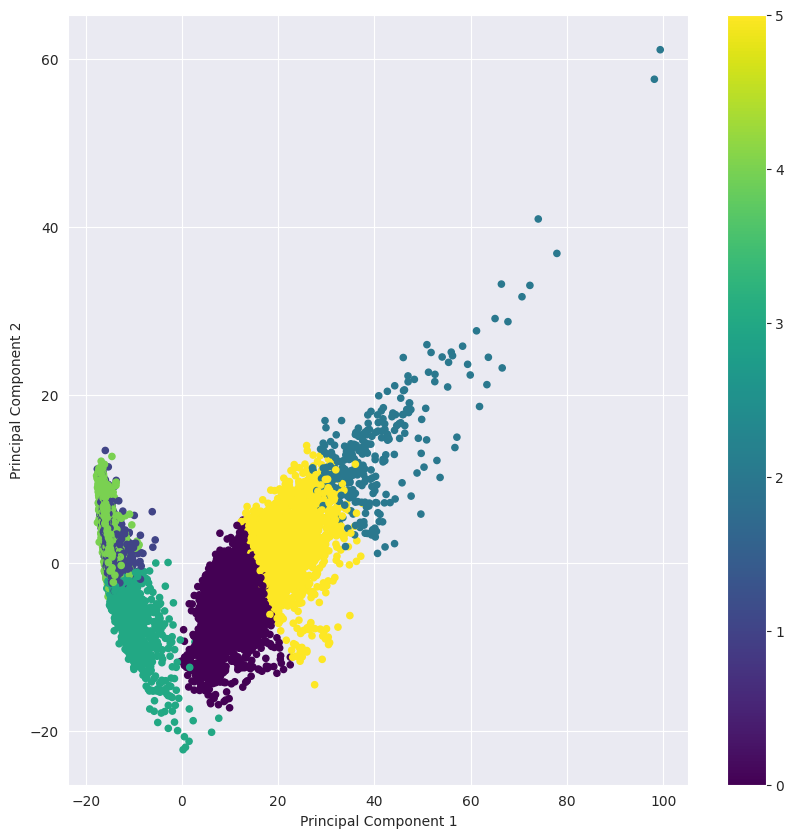

In [51]:
# Ваш код здесь
plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=my_predicted_labels, s=20,  cmap='viridis')
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [52]:
tab = pd.crosstab(y, my_predicted_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,901,0,78,0,0,743,1722
подъем вверх по лестнице,1239,0,5,2,0,298,1544
спуск по лестнице,319,0,196,0,0,891,1406
сидение,1,1235,0,450,91,0,1777
стояние,0,1344,0,562,0,0,1906
лежание,5,52,0,329,1558,0,1944
все,2465,2631,279,1343,1649,1932,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

In [53]:
print(f'Ходьба:                   {901 / 1722}')
print(f'Подъем вверх по лестнице: {1239 / 1544}')
print(f'Спуск по лестнице:        {891 / 1406}')
print(f'Сидение:                  {1235 / 1777}')
print(f'Стояние:                  {1344 / 1906}')
print(f'Лежание:                  {1558 / 1944}')

Ходьба:                   0.5232288037166086
Подъем вверх по лестнице: 0.802461139896373
Спуск по лестнице:        0.6337126600284495
Сидение:                  0.694991558806978
Стояние:                  0.7051416579223505
Лежание:                  0.801440329218107


Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [54]:
from tqdm import tqdm 

inertia = []

for k in tqdm(range(1, n_classes + 1), desc='Calculating inertia'):
    current_model = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    current_model.fit(X_pca)
    inertia.append(current_model.inertia_)

Calculating inertia: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


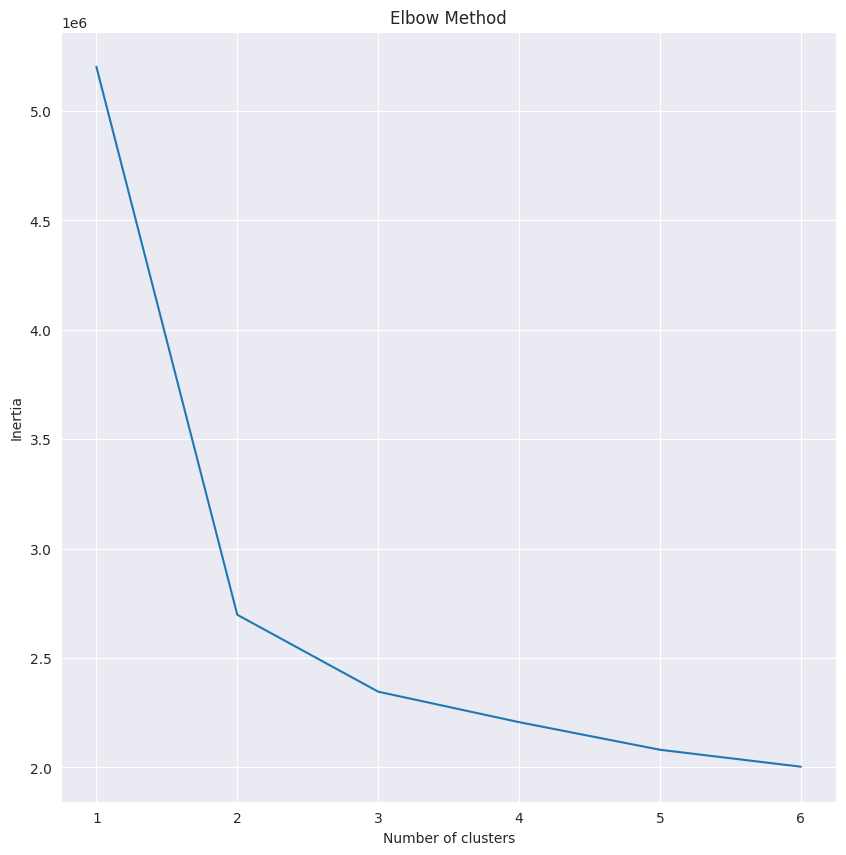

In [55]:
plt.figure(figsize=(10, 10))
plt.plot(range(1, n_classes + 1),
        inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [56]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)
ag_labels = ag.labels_

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [57]:
# Ваш код здесь
from sklearn.metrics import adjusted_rand_score

sklearn_kmeans_model = KMeans(n_clusters=n_classes, 
                            random_state=RANDOM_STATE,
                            n_init=100).fit(X_pca)

kmeans_predicted_labels = sklearn_kmeans_model.labels_

agglomerative_ari = adjusted_rand_score(y, ag_labels)
kmeans_ari = adjusted_rand_score(y, kmeans_predicted_labels)

print(f'ARI for Agglomerative Clustering: {agglomerative_ari}')
print(f'ARI for K-Means Clustering:       {kmeans_ari}')

ARI for Agglomerative Clustering: 0.49362763373004886
ARI for K-Means Clustering:       0.4198070012602345


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [58]:
# Ваш код здесь
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [59]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [60]:
# Ваш код здесь
current_grid_search = GridSearchCV(estimator=svc, cv=3, param_grid=svc_params, n_jobs=-1)
current_grid_search.fit(X_train_scaled, y_train)
best_svc = current_grid_search.best_estimator_
best_validation_score = current_grid_search.best_score_

In [61]:
# Ваш код здесь
print(f'Точность на тренировочном наборе: {best_validation_score}')
print(f'Точность на тестовом наборе: {best_svc.score(X_test_scaled, y_test)}')
print(f'Лучшие подобранные параметры модели: {current_grid_search.best_params_}')

Точность на тренировочном наборе: 0.9379785010699506
Точность на тестовом наборе: 0.9619952494061758
Лучшие подобранные параметры модели: {'C': 0.1}


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [62]:
y_predicted = best_svc.predict(X_test_scaled)

In [63]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

In [64]:
from sklearn.metrics import precision_score, recall_score

all_classes_precision = precision_score(y_true=y_test, y_pred=y_predicted, labels=np.arange(1, 7), average=None)
all_classes_recall = recall_score(y_true=y_test, y_pred=y_predicted, labels=np.arange(1, 7), average=None)
min_precision_index = np.argmin(all_classes_precision)
min_recall_index = np.argmin(all_classes_recall)
print(f'Index of activity with least precision: {min_precision_index + 1}')
print(f'Index of activity with least recall: {min_recall_index + 1}')

activities = {
    1: 'ходьба',
    2: 'подъем вверх по лестнице',
    3: 'спуск по лестнице',
    4: 'сидение',
    5: 'стояние',
    6: 'лежание'
}

print(f'Activity with least precision: {activities[min_precision_index + 1]}')
print(f'Activity with least recall: {activities[min_recall_index + 1]}')


Index of activity with least precision: 5
Index of activity with least recall: 4
Activity with least precision: стояние
Activity with least recall: сидение


In [65]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(estimator=svc, param_grid=svc_params, cv=3, n_jobs=-1)
grid.fit(X_train_pca, y_train)

,estimator,LinearSVC(random_state=17)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


In [66]:
print(f'{round((current_grid_search.best_score_ - grid.best_score_) * 100)}%')

4%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

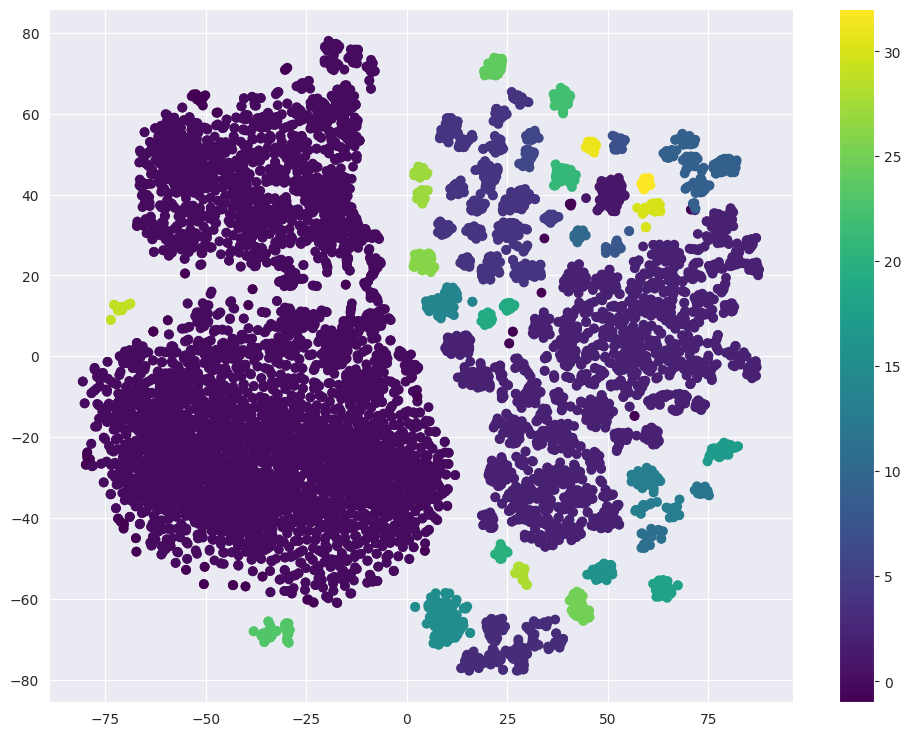

In [67]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

current_tsne = TSNE(random_state=RANDOM_STATE)
X_transformed = current_tsne.fit_transform(X_scaled)

current_dbscan = DBSCAN(eps=4, min_samples=20)
results = current_dbscan.fit_predict(X_transformed)

plt.scatter(X_transformed[:, 0], 
            X_transformed[:, 1], 
            c=results, 
            cmap='viridis',
            edgecolors='none',
            s=50) 
plt.colorbar()